In [1]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn 
import pandas as pd 
import os 
import sys
import time 
import tensorflow as tf 
from tensorflow import keras 

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.5
pandas 1.0.4
sklearn 0.23.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
# TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
# TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

# train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
# test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

16384/13049 [=====================================] - 0s 2us/step


In [4]:
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df)

     survived     sex   age  n_siblings_spouses  parch     fare   class  \
0           0    male  22.0                   1      0   7.2500   Third   
1           1  female  38.0                   1      0  71.2833   First   
2           1  female  26.0                   0      0   7.9250   Third   
3           1  female  35.0                   1      0  53.1000   First   
4           0    male  28.0                   0      0   8.4583   Third   
..        ...     ...   ...                 ...    ...      ...     ...   
622         0    male  28.0                   0      0  10.5000  Second   
623         0    male  25.0                   0      0   7.0500   Third   
624         1  female  19.0                   0      0  30.0000   First   
625         0  female  28.0                   1      2  23.4500   Third   
626         0    male  32.0                   0      0   7.7500   Third   

        deck  embark_town alone  
0    unknown  Southampton     n  
1          C    Cherbourg     n

In [5]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [7]:
train_df.describe()
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


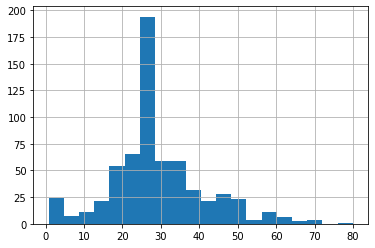

In [8]:
train_df.age.hist(bins = 20)

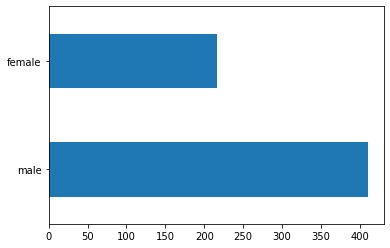

In [10]:
train_df.sex.value_counts().plot(kind = 'barh')

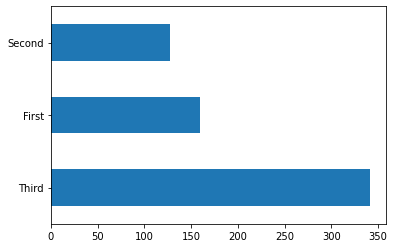

In [12]:
train_df['class'].value_counts().plot(kind = 'barh')

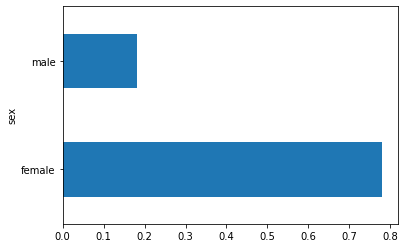

In [14]:
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind='barh')

In [35]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                      'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))
for num_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            num_column, dtype = tf.float32))
    


sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [20]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True,
                batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
        
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset
    

In [21]:
train_dataset = make_dataset(train_df, y_train, batch_size=5)

In [22]:
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'male', b'female', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([22., 16., 48., 50., 32.])>, 'n_siblings_spouses': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 1, 0])>, 'parch': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 0, 0, 0])>, 'fare': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([  7.25  ,  39.4   ,   7.8542, 106.425 ,   7.8958])>, 'class': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Third', b'First', b'Third', b'First', b'Third'], dtype=object)>, 'deck': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'D', b'unknown', b'C', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Cherbourg',
       b'Southampton'], dtype=object)>, 'alone': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'n', b'n', b'y', b'n', b'y'],

In [38]:
# keras.layers.DenseFeature 
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[27.]
 [28.]
 [28.]
 [32.]
 [28.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

In [39]:
# keras.layers.DenseFeature 
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[44.    1.    0.    0.    0.    1.    1.    0.    0.    0.    0.    0.
   0.    0.    1.    0.    0.    0.   26.    1.    0.    0.    0.    0.
   0.    0.    1.    0.    0.    0.    0.    0.    1.    0.  ]
 [26.    1.    0.    0.    0.    1.    1.    0.    0.    0.    0.    0.
   0.    0.    1.    0.    0.    0.   26.    1.    0.    0.    0.    0.
   0.    0.    0.    1.    0.    0.    0.    0.    0.    1.  ]
 [22.    0.    1.    1.    0.    0.    1.    0.    0.    0.    0.    0.
   0.    0.    1.    0

In [40]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(2, activation = 'softmax'),
])

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = keras.optimizers.SGD(lr=0.01),
             metrics = ['accuracy'])


In [42]:
# 1. model fit 
# 2. model -> estimator -> train 
train_dataset = make_dataset(train_df, y_train, epochs = 100)
eval_dataset = make_dataset(eval_df, y_eval, epochs = 1, shuffle = False)
history = model.fit(train_dataset,
                   validation_data= eval_dataset,
                   steps_per_epoch=20,
                   validation_steps=8,
                   epochs=10)

Epoch 1/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5081 - accuracy: 0.7797 - val_loss: 0.4827 - val_accuracy: 0.7852
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5044 - accuracy: 0.7828 - val_loss: 0.5332 - val_accuracy: 0.7344
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5191 - accuracy: 0.7516 - val_loss: 0.4920 - val_accuracy: 0.7617
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4905 - accuracy: 0.7719 - val_loss: 0.5533 - val_accuracy: 0.7461
Epoch 5/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5233 - accuracy: 0.7688 - val_loss: 0.4854 - val_accuracy: 0.7852
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5125 - accuracy: 0.7625 - val_loss: 0.5183 - val_accuracy: 0.7305
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4818 - accuracy: 0.7828 - val_loss: 0.4895 - val_accuracy: 0.7812
Epoch 8/10
20/20 [==

In [49]:
estimator = keras.estimator.model_to_estimator(model)
# 1. function 
# 2. return a. (features, labels) b. dataset -> (feature, label)
estimator.train(input_fn = lambda : make_dataset(train_df, y_train, epochs=100))



INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/kc/7jwtb8cx5fn6_blvwqs45h400000gn/T/tmps60k6qup', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master'

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.